<p align="center">
<img src='https://github.com/manuelmorgado/AQiPT/blob/main/resources/aqipt_logo.png?raw=true' width="400" />
</p>


\textbf{Author}: Manuel A. Morgado V. 

\textbf{Affiliation}: 

- \textit{Institut de Science et d’Ingénierie Supramoléculaires (ISIS, UMR7006), University of Strasbourg and CNRS}

- \textit{Centre Européen de Sciences Quantiques (CESQ-ISIS, UMR7006), University of Strasbourg and CNRS}

\textbf{Contributors}: 

\textbf{Affiliation}: 

\textbf{Created}: Jul.27, 2021

\textbf{Last Modification}: Aug.09, 2021

\textbf{License}: http://www.apache.org/licenses/LICENSE-2.0

In [1]:
#libs
import numpy as np
import qutip as qt

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

from IPython.display import clear_output
from IPython.core.display import HTML, display
display(HTML("<style>.container { width:85% !important; }</style>"))

from functools import reduce
from typing import Iterator, List

import warnings
warnings.filterwarnings('ignore')

import networkx as nx

import AQiPTc as aqipt

# Class `atomicModel()`

In [2]:
#atomicModel class

def basis_nlvl(n):
        '''
            Basis state for n-lvl system

            Creates the eigenbasis of the n-level system

            INPUTS
                n : number of levels of the system

            OUTPUTS
                basis_lst (array) : eigenbasis as array object in the order |1>, |2>...

        '''
        basis_lst = [qt.basis(n, state) for state in range(n)];
        return np.array(basis_lst, dtype=object)

def ops_nlvl(n, basis_lst = None):
    '''
        Operators basis for n-lvl system

        Creates the operators basis of the n-level system

        INPUTS
            n : number of levels of the system
            basis_lst : list of the system eigenbasis

        OUTPUTS
            proyectors (array) : operator basis as array object in the order |1><1|, |1><2|...
            basis (array) : eigenbasis as array object in the order |1>, |2>...

    '''
    if basis_lst == None:
        basis = basis_nlvl(n);
        proyectors = [ket1*ket2.dag() for ket1 in basis for ket2 in basis];

        return np.array(proyectors, dtype=object), basis
    else:
        basis = basis_lst;
        proyectors = [ket1*ket2.dag() for ket1 in basis for ket2 in basis];

        return proyectors

def iden(n):
    '''
        n-lvl identity operator

        Creates the identity operator for the n-level system

        INPUTS
            n : number of levels of the system

        OUTPUTS
            (QuTip object) : n by n square matrix with diagonal 1
    '''
    return qt.identity(n) #nxn identity operator

def lst2str(lst):
    return ''.join(str(e) for e in lst)

class atomicModel:
    
    """
        A class for develope models based in the n-level system of an atomic register. AQiPT atomicModel()
        class contain the basic toolbox for solve, time-dependent and -independent dynamics for 1 or
        more physical atomic qubits with the help of the AQiPT control-module using the class of 
        functions, pulses, tracks, sequence etc.

        The pulse class is the AQiPT core of the emulator for the dynamics of the qubits. From this
        class is possible to generate and store the Hamiltonians, Lindbladians, Observables, quantum
        registers maps and plot results for later use of other modules of AQiPT.


        Parameters
        ----------
        times : array_like
            Time of dynamics to be emulated.
        Nrlevels : int
            Number of levels of the quantum system.
        initState : int
            Initial state for the dynamics starting from 0 to any n.
        params : dict
            Dictionary with parameters of dynamcis e.g., couplings, detunings, dissipators, pulses
        name : str
            Label for the model

        Attributes
        ----------
        times : array_like
            Time of dynamics to be emulated.
        Nrlevels : int
            Number of levels of the quantum system.
        initState : Qobj() [QuTiP]
            Initial ensity matrix.
        dynParams : dict
            Dictionary with parameters of dynamcis e.g., couplings, detunings, dissipators, pulses
        Hamiltonian : Qobj() [QuTiP]
            Hamiltonian as QuTiP object
        cops : Qobj() list [QuTiP]
            List of Lindbladians as QuTiP objects
        mops : Qobj() list [QuTiP]
            List of Observables as QuTiP objects
        _ops : list
            Full list of operators that spam the system
        _basis : list 
            Full list of eigenstates of the system
        atomicRegister :
            Graph object of the n-level system
        _name : str
            Name of the model AQiPT object
        simOpts : Qobj() [QuTiP]
            Options QuTiP object for the mesolve() master equation solver
        simRes : Qobj() list [QuTiP]
            List of Qobj() related to the density matrix rho as function of time

        Methods
        -------
        playSIM()
            Solve QME for the Nrlevels-system at initState using params.
        buildHamiltonian()
            Construct Hamiltonians as QuTip object (Hermitian)
        buildLindbladians()
            Construct Lindbladians as QuTip object (Non-Hermitian)
        buildObservables()
            Construct Observables as QuTip object (Hermitian)
        getResult()
            Return result values from simulation as a list of QuTip objects (Hermitian)
        showResults()
            Plot results coming from the simulation
        registerMap()
            Plot the graph associated to the n-level system of the atomic quantum register
            
    """
    
    
    def __init__(self, times, Nrlevels, initState, params, name='model'):#, NrQReg=1, Homogeneous=True):
        
        ops, basis = ops_nlvl(Nrlevels);
        
        #atributes
        self.times = times
        self.Nrlevels = Nrlevels
        self.initState = basis[initState]
        
        self.dynParams = params
        self.Hamiltonian = None #total Hamiltonian of the model (single matrix)
        self.tHamiltonian = None #time-dependent Hamiltonian as QObjEVO() of QuTiP
        self.Hpulses = None #time-dependency of the Hamiltonian a.k.a pulses
        self._lstHamiltonian = [] #list of Hamiltonians of the system
        
        self.cops = None #lindbladians
        self.mops = None #observables

        self._ops = ops #eigenoperators
        self._basis = basis #eigenbasis
        self.atomicRegister = {}
        
        self._name = name
        self.simOpts = qt.Options(nsteps=500, rtol=1e-7, max_step=10e-1)
        self.simRes = None
    
    
    def playSim(self, mode='free'):
        
        if mode=='free':
            self.simRes = qt.mesolve(self.Hamiltonian, qt.ket2dm(self.initState), self.times, c_ops=self.cops, e_ops=self.mops, options=self.simOpts)
        elif mode=='control':
            self.simRes = qt.mesolve(self.tHamiltonian, qt.ket2dm(self.initState), self.times, c_ops=self.cops, e_ops=self.mops, options=self.simOpts)
    
    def buildTHamiltonian(self):
        _HQobjEVO = [];
        _HAQiPTpulses = [];
        for element in range(len(self.dynParams['couplings'])):
            _HStruct = self.dynParams['couplings']['Coupling'+str(element)][1] * (self._ops[(self.dynParams['couplings']['Coupling'+str(element)][0])[0]*self.Nrlevels + (self.dynParams['couplings']['Coupling'+str(element)][0])[1]] + self._ops[(self.dynParams['couplings']['Coupling'+str(element)][0])[0]*self.Nrlevels + (self.dynParams['couplings']['Coupling'+str(element)][0])[1]].dag())
            _HtDependency = self.dynParams['couplings']['Coupling'+str(element)][2]
            _HAQiPTpulses.append(_HtDependency)
            _HQobjEVO.append([_HStruct, _HtDependency])
            self._lstHamiltonian.append(_HStruct)
        self.tHamiltonian = _HQobjEVO
        self.Hpulses = _HAQiPTpulses
        
    def buildHamiltonian(self):
        HD = sum([self.dynParams['couplings']['Coupling'+str(element)][1] * (self._ops[(self.dynParams['couplings']['Coupling'+str(element)][0])[0]*self.Nrlevels + (self.dynParams['couplings']['Coupling'+str(element)][0])[1]] + self._ops[(self.dynParams['couplings']['Coupling'+str(element)][0])[0]*self.Nrlevels + (self.dynParams['couplings']['Coupling'+str(element)][0])[1]].dag()) for element in range(len(self.dynParams['couplings'])) ]);
        HoffD = sum([self.dynParams['detunings']['Detuning'+str(element)][1]*(self._ops[(self.dynParams['detunings']['Detuning'+str(element)][0])[0]*self.Nrlevels + (self.dynParams['detunings']['Detuning'+str(element)][0])[1]] ) for element in range(len(self.dynParams['detunings'])) ]);
        self.Hamiltonian = HD + HoffD;
    
    def buildLindbladians(self):
        self.cops = [np.sqrt(self.dynParams['dissipators']['Dissipator'+str(element)][1])*(self._ops[(self.dynParams['dissipators']['Dissipator'+str(element)][0])[0]*self.Nrlevels + (self.dynParams['dissipators']['Dissipator'+str(element)][0])[1]]) for element in range(len(self.dynParams['dissipators']))]
    
    def buildObservables(self):
        self.mops = [self._ops[(self.Nrlevels+1)*i] for i in range(self.Nrlevels)]
        
    def getResult(self):
        return self.simRes
    
    def showResults(self, resultseq=None):
        
        if resultseq==None:
            resultseq = self.simRes
        
        fig, axs = plt.subplots();

        for i in range(len(resultseq.expect)):
            axs.plot(times, resultseq.expect[i], label=i);

        plt.legend();
        plt.xlabel('Time', fontsize=18);
        plt.ylabel('Population', fontsize=18)

        return fig, axs
    
    def registerMap(self, plotON=True):
        
        for state in range(self.Nrlevels):
            self.atomicRegister[state] = []
        
        for coupling in self.dynParams['couplings'].items():
            i, j = coupling[1][0];
            self.atomicRegister[i].append(j)
            self.atomicRegister[j].append(i)
        
        G = nx.MultiDiGraph(self.atomicRegister, create_using=nx.DiGraph, seed = 100)
        
        edgelist = []
        for dissipator in self.dynParams['dissipators'].items():    
            i,j = dissipator[1][0];
            if i==j:
                edgelist.append(tuple([i,j]));
        G.add_edges_from(edgelist)

        if plotON==True:
            pos = nx.circular_layout(G)
            nx.draw(G, with_labels=True, font_weight='regular',node_size=400, linewidths=5, font_size=15)
            nx.draw_networkx_edges(G, pos, edgelist=edgelist, arrowstyle="<|-", style="solid")
        return self.atomicRegister
    

# Single Quantum Register models

## 2-lvl system

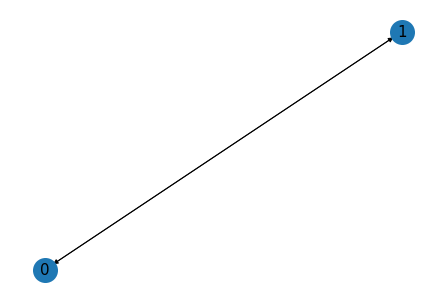

In [3]:
Nrlevels = 2; #nr of levels in the system
psi0 = 0; #initial state
"""
coupling0 -> CoupingRed-767nm
Detuning0 ->
"""
times = np.linspace(0, 1, 200); #time of the dynamics
couplings = {'Coupling0': [[0,1], 2*np.pi*16,  None]}; #couplings list within the states [i,j], couplingValue, pulse
detunings = {'Detuning0': [[1,1], -2*np.pi*0,  None]}; #detuning list in the state i as [i,i], detuningValue, pulse          
dissipators = {'Dissipator0': [[0,1], 2*np.pi*1]}; #dissipator list within the states [i,j], dissipatorStrenght



params = {'couplings': couplings, 
          'detunings': detunings, 
          'dissipators': dissipators}; #wrapping dynamic params in dictionary

qubit = atomicModel(times, Nrlevels, psi0, params, name = '2-lvl')#, NrQReg=1, Homogeneous=True); #model class of AQiPT model(timeOfdynamics, NumberOfLevels, InitialState, DynamicParams, NameLabel)

qubitMap = qubit.registerMap(plotON=True); #defining the map of the AtomicQuantumRegister

In [4]:
qubit.buildHamiltonian(); #building Hamiltonians
qubit.buildLindbladians(); #building Lindbladians
qubit.buildObservables(); #building Observables

In [5]:
qubit.Hamiltonian

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[  0.         100.53096491]
 [100.53096491   0.        ]]

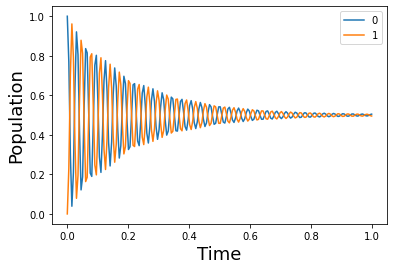

In [6]:
qubit.playSim(); #playing simulation
qubit.showResults(); #showing simulation results

### Some properties of the class

In [7]:
qubit.getResult()

Result object with mesolve data.
--------------------------------
expect = True
num_expect = 2, num_collapse = 1

In [8]:
qubit.dynParams

{'couplings': {'Coupling0': [[0, 1], 100.53096491487338, None]},
 'detunings': {'Detuning0': [[1, 1], -0.0, None]},
 'dissipators': {'Dissipator0': [[0, 1], 6.283185307179586]}}

## 3-lvl system

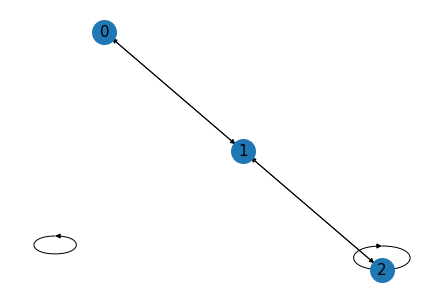

In [9]:
Nrlevels = 3; #nr of levels in the system
psi0 = 0; #initial state
times = np.linspace(0, 1, 200); #time of the dynamics

couplings = {'Coupling0': [[0,1], 2*np.pi*10,  None], 
             'Coupling1': [[1,2], 2*np.pi*2,  None]}; #couplings list within the states [i,j], couplingValue, pulse

detunings = {'Detuning0': [[1,1], -2*np.pi*10,  None],
             'Detuning1': [[2,2], 2*np.pi*5,  None]}; #detuning list in the state i as [i,i], detuningValue, pulse 

dissipators = {'Dissipator0': [[0,1],2*np.pi*0],
               'Dissipator1': [[0,2],2*np.pi*0],
               'Dissipator2': [[2,2],2*np.pi*0]}; #dissipator list within the states [i,j], dissipatorStrenght

params = {'couplings': couplings, 
          'detunings': detunings, 
          'dissipators': dissipators}; #wrapping dynamic params in dictionary

qutrit = atomicModel(times, Nrlevels, psi0, params, name = '3-lvl'); #model class of AQiPT model(timeOfdynamics, NumberOfLevels, InitialState, DynamicParams, NameLabel)

qutritMap = qutrit.registerMap(plotON=True); #defining the map of the AtomicQuantumRegister

In [10]:
qutrit.buildHamiltonian(); #building Hamiltonians
qutrit.buildLindbladians(); #building Lindbladians
qutrit.buildObservables(); #building Observables

In [11]:
qutrit.initState

Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]]

In [12]:
qutrit.Hamiltonian

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[  0.          62.83185307   0.        ]
 [ 62.83185307 -62.83185307  12.56637061]
 [  0.          12.56637061  31.41592654]]

In [13]:
qutrit.mops

[Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
 Qobj data =
 [[1. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]],
 Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
 Qobj data =
 [[0. 0. 0.]
  [0. 1. 0.]
  [0. 0. 0.]],
 Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
 Qobj data =
 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 1.]]]

In [14]:
qutrit.cops

[Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
 Qobj data =
 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]],
 Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
 Qobj data =
 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]],
 Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
 Qobj data =
 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]

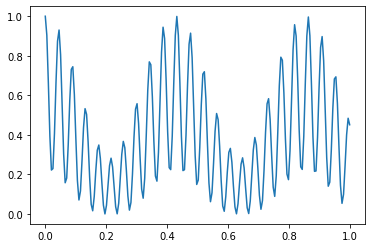

In [15]:
results = qt.mesolve(qutrit.Hamiltonian, qutrit.initState, qutrit.times, c_ops=qutrit.cops, e_ops=qutrit.mops, options=qutrit.simOpts)
plt.plot(qutrit.times, results.expect[0]);

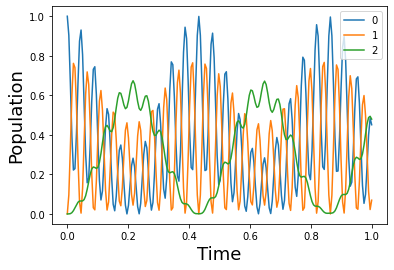

In [16]:
qutrit.playSim(); #playing simulation
qutrit.showResults(); #showing simulation results

## 4-lvl system

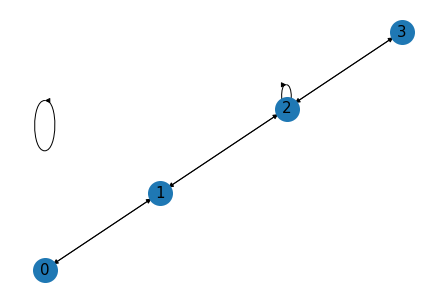

In [17]:
Nrlevels = 4; 
psi0 = 0; 
times = np.linspace(0, 1, 200); 

couplings = {'Coupling0': [[0,1], 2*np.pi*10,  None], 
             'Coupling1': [[1,2], 2*np.pi*2,  None],
             'Coupling2': [[2,3], 2*np.pi*2,  None]};
detunings = {'Detuning0': [[1,1], -2*np.pi*1,  None],
             'Detuning1': [[2,2], 2*np.pi*1,  None],
             'Detuning2': [[3,3], 2*np.pi*1,  None]}; 
dissipators = {'Dissipator0': [[0,1],2*np.pi*6],
               'Dissipator1': [[0,2],2*np.pi*0],
               'Dissipator2': [[2,2],2*np.pi*100]};

params = {'couplings': couplings, 
          'detunings': detunings, 
          'dissipators': dissipators};

qudit4 = atomicModel(times, Nrlevels, psi0, params, name = '4-lvl'); 

qudit4Map = qudit4.registerMap(plotON=True); 

In [18]:
qudit4.buildHamiltonian();
qudit4.buildLindbladians(); 
qudit4.buildObservables(); 

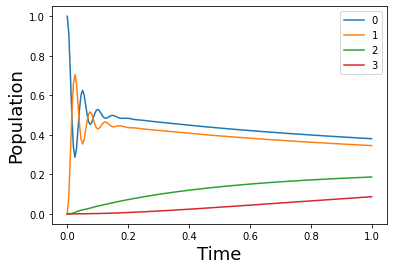

In [19]:
qudit4.playSim();
qudit4.showResults();

## 5-lvl system

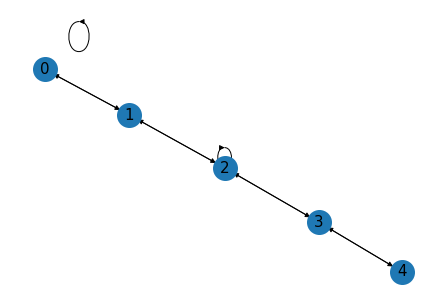

In [20]:
Nrlevels = 5; 
psi0 = 0; 
times = np.linspace(0, 1, 200); 

couplings = {'Coupling0': [[0,1], 2*np.pi*10,  None], 
             'Coupling1': [[1,2], 2*np.pi*2,  None],
             'Coupling2': [[2,3], 2*np.pi*2,  None],
             'Coupling3': [[3,4], 2*np.pi*2,  None]};

detunings = {'Detuning0': [[1,1], -2*np.pi*1,  None],
             'Detuning1': [[2,2], 2*np.pi*1,  None],
             'Detuning2': [[3,3], 2*np.pi*1,  None],
             'Detuning3': [[4,4], 2*np.pi*1,  None]};

dissipators = {'Dissipator0': [[0,1],2*np.pi*6],
               'Dissipator1': [[0,2],2*np.pi*0],
               'Dissipator2': [[2,2],2*np.pi*1]};

params = {'couplings': couplings, 
          'detunings': detunings, 
          'dissipators': dissipators};

qudit5 = atomicModel(times, Nrlevels, psi0, params, name = '5-lvl'); 

qudit5Map = qudit5.registerMap(plotON=True); 

In [21]:
qudit5.buildHamiltonian(); 
qudit5.buildLindbladians(); 
qudit5.buildObservables(); 

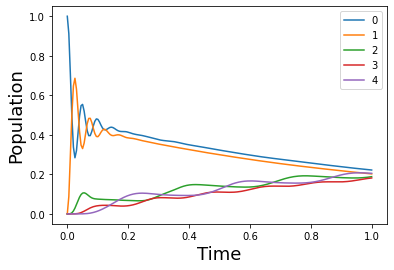

In [22]:
qudit5.playSim();
qudit5.showResults();

## 6-lvl system

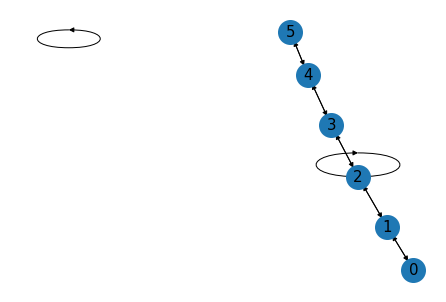

In [23]:
Nrlevels = 6; 
psi0 = 0; 
times = np.linspace(0, 1, 200); 

couplings = {'Coupling0': [[0,1], 2*np.pi*10,  None], 
             'Coupling1': [[1,2], 2*np.pi*4,  None],
             'Coupling2': [[2,3], 2*np.pi*6,  None],
             'Coupling3': [[3,4], 2*np.pi*5,  None],
             'Coupling4': [[4,5], 2*np.pi*7,  None]};

detunings = {'Detuning0': [[1,1], -2*np.pi*1,  None],
             'Detuning1': [[2,2], 2*np.pi*1,  None],
             'Detuning2': [[3,3], 2*np.pi*1,  None],
             'Detuning3': [[4,4], 2*np.pi*5,  None],
             'Detuning4': [[5,5], 2*np.pi*1,  None]}; 

dissipators = {'Dissipator0': [[0,1],2*np.pi*3],
               'Dissipator1': [[0,2],2*np.pi*5],
               'Dissipator2': [[2,2],2*np.pi*3]};

params = {'couplings': couplings, 
          'detunings': detunings, 
          'dissipators': dissipators};

qudit6 = atomicModel(times, Nrlevels, psi0, params, name = '6-lvl'); 

qudit6Map = qudit6.registerMap(plotON=True); 

In [24]:
qudit6.buildHamiltonian(); 
qudit6.buildLindbladians(); 
qudit6.buildObservables(); 

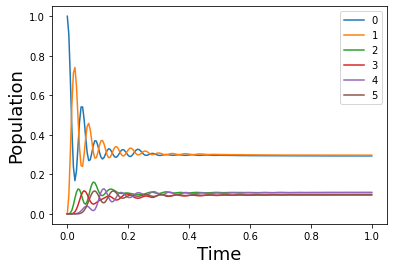

In [25]:
qudit6.playSim();
qudit6.showResults();

## 7-lvl system

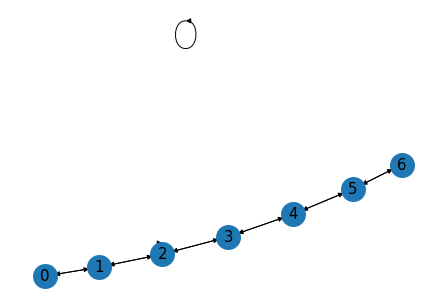

In [26]:
Nrlevels = 7; 
psi0 = 0; 
times = np.linspace(0, 1, 200); 

couplings = {'Coupling0': [[0,1], 2*np.pi*7,  None], 
             'Coupling1': [[1,2], 2*np.pi*2,  None],
             'Coupling2': [[2,3], 2*np.pi*6,  None],
             'Coupling3': [[3,4], 2*np.pi*2,  None],
             'Coupling4': [[4,5], 2*np.pi*6,  None],
             'Coupling5': [[5,6], 2*np.pi*4,  None]};

detunings = {'Detuning0': [[1,1], -2*np.pi*1,  None],
             'Detuning1': [[2,2], 2*np.pi*1,  None],
             'Detuning2': [[3,3], 2*np.pi*1,  None],
             'Detuning3': [[4,4], 2*np.pi*5,  None],
             'Detuning4': [[5,5], 2*np.pi*1,  None],
             'Detuning5': [[6,6], 2*np.pi*1,  None]}; 

dissipators = {'Dissipator0': [[0,1],2*np.pi*6],
               'Dissipator1': [[0,2],2*np.pi*0],
               'Dissipator2': [[2,2],2*np.pi*3]};

params = {'couplings': couplings, 
          'detunings': detunings, 
          'dissipators': dissipators};

qudit7 = atomicModel(times, Nrlevels, psi0, params, name = '7-lvl'); 

qudit7Map = qudit7.registerMap(plotON=True);

In [27]:
qudit7.buildHamiltonian(); 
qudit7.buildLindbladians(); 
qudit7.buildObservables(); 

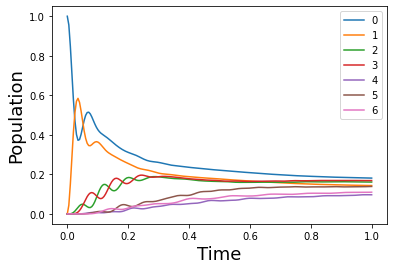

In [28]:
qudit7.playSim();
qudit7.showResults();

## 8-lvl system

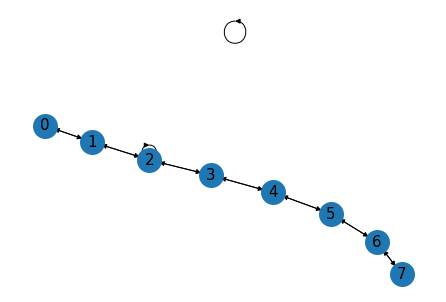

In [29]:
Nrlevels = 8; 
psi0 = 0; 
times = np.linspace(0, 1, 200); 

couplings = {'Coupling0': [[0,1], 2*np.pi*7,  None], 
             'Coupling1': [[1,2], 2*np.pi*2,  None],
             'Coupling2': [[2,3], 2*np.pi*6,  None],
             'Coupling3': [[3,4], 2*np.pi*2,  None],
             'Coupling4': [[4,5], 2*np.pi*6,  None],
             'Coupling5': [[5,6], 2*np.pi*4,  None],
             'Coupling6': [[6,7], 2*np.pi*2,  None]};

detunings = {'Detuning0': [[1,1], -2*np.pi*1,  None],
             'Detuning1': [[2,2], 2*np.pi*1,  None],
             'Detuning2': [[3,3], 2*np.pi*1,  None],
             'Detuning3': [[4,4], 2*np.pi*5,  None],
             'Detuning4': [[5,5], 2*np.pi*1,  None],
             'Detuning5': [[6,6], 2*np.pi*1,  None],
             'Detuning6': [[7,7], 2*np.pi*6,  None]}; 

dissipators = {'Dissipator0': [[0,1],2*np.pi*6],
               'Dissipator1': [[0,2],2*np.pi*0],
               'Dissipator2': [[2,2],2*np.pi*3]};

params = {'couplings': couplings, 
          'detunings': detunings, 
          'dissipators': dissipators};

qudit8 = atomicModel(times, Nrlevels, psi0, params, name = '8-lvl'); 

qudit8Map = qudit8.registerMap(plotON=True); 

In [30]:
qudit8.buildHamiltonian(); 
qudit8.buildLindbladians();
qudit8.buildObservables(); 

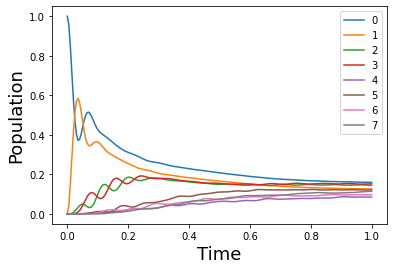

In [31]:
qudit8.playSim();
qudit8.showResults();

## 9-lvl system

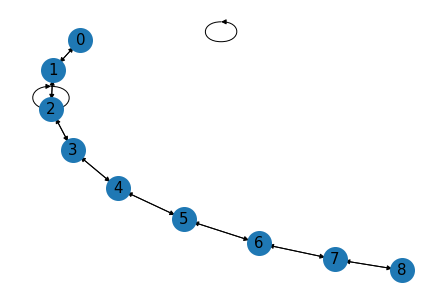

In [32]:
Nrlevels = 9; 
psi0 = 0; 
times = np.linspace(0, 1, 200); 

couplings = {'Coupling0': [[0,1], 2*np.pi*7,  None], 
             'Coupling1': [[1,2], 2*np.pi*2,  None],
             'Coupling2': [[2,3], 2*np.pi*6,  None],
             'Coupling3': [[3,4], 2*np.pi*2,  None],
             'Coupling4': [[4,5], 2*np.pi*6,  None],
             'Coupling5': [[5,6], 2*np.pi*4,  None],
             'Coupling6': [[6,7], 2*np.pi*2,  None],
             'Coupling7': [[7,8], 2*np.pi*0.1,  None]};

detunings = {'Detuning0': [[1,1], -2*np.pi*1,  None],
             'Detuning1': [[2,2], 2*np.pi*1,  None],
             'Detuning2': [[3,3], 2*np.pi*1,  None],
             'Detuning3': [[4,4], 2*np.pi*5,  None],
             'Detuning4': [[5,5], 2*np.pi*1,  None],
             'Detuning5': [[6,6], 2*np.pi*1,  None],
             'Detuning6': [[7,7], 2*np.pi*6,  None],
             'Detuning7': [[8,8], 2*np.pi*1,  None]}; 

dissipators = {'Dissipator0': [[0,1],2*np.pi*6],
               'Dissipator1': [[0,2],2*np.pi*0],
               'Dissipator2': [[2,2],2*np.pi*3]};

params = {'couplings': couplings, 
          'detunings': detunings, 
          'dissipators': dissipators};

qudit9 = atomicModel(times, Nrlevels, psi0, params, name = '4-lvl'); 

qudit9Map = qudit9.registerMap(plotON=True); 

In [33]:
qudit9.buildHamiltonian(); 
qudit9.buildLindbladians(); 
qudit9.buildObservables(); 

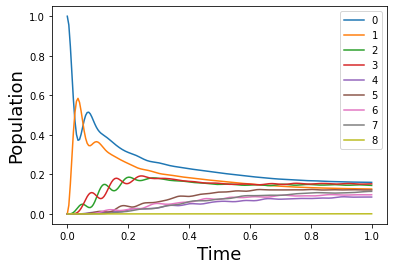

In [34]:
qudit9.playSim();
qudit9.showResults();

## 10-lvl system

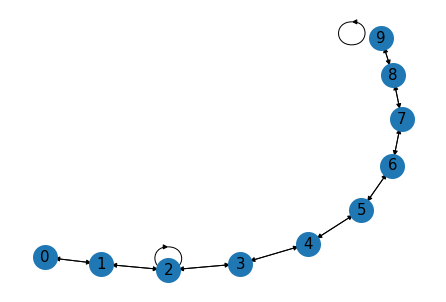

In [35]:
Nrlevels = 10; 
psi0 = 0;
times = np.linspace(0, 1, 200); 

couplings = {'Coupling0': [[0,1], 2*np.pi*7,  None], 
             'Coupling1': [[1,2], 2*np.pi*2,  None],
             'Coupling2': [[2,3], 2*np.pi*6,  None],
             'Coupling3': [[3,4], 2*np.pi*2,  None],
             'Coupling4': [[4,5], 2*np.pi*0,  None],
             'Coupling5': [[5,6], 2*np.pi*4,  None],
             'Coupling6': [[6,7], 2*np.pi*2,  None],
             'Coupling7': [[7,8], 2*np.pi*0.1,  None],
             'Coupling8': [[8,9], 2*np.pi*2,  None]};

detunings = {'Detuning0': [[1,1], -2*np.pi*1,  None],
             'Detuning1': [[2,2], 2*np.pi*1,  None],
             'Detuning2': [[3,3], 2*np.pi*1,  None],
             'Detuning3': [[4,4], 2*np.pi*5,  None],
             'Detuning4': [[5,5], 2*np.pi*1,  None],
             'Detuning5': [[6,6], 2*np.pi*1,  None],
             'Detuning6': [[7,7], 2*np.pi*6,  None],
             'Detuning7': [[8,8], 2*np.pi*1,  None],
             'Detuning8': [[9,9], 2*np.pi*4,  None]}; 

dissipators = {'Dissipator0': [[0,1],2*np.pi*6],
               'Dissipator1': [[0,2],2*np.pi*0],
               'Dissipator2': [[2,2],2*np.pi*3]};

params = {'couplings': couplings, 
          'detunings': detunings, 
          'dissipators': dissipators};

qudit10 = atomicModel(times, Nrlevels, psi0, params, name = '10-lvl'); 

qudit10Map = qudit10.registerMap(plotON=True); 

In [36]:
qudit10.buildHamiltonian(); 
qudit10.buildLindbladians(); 
qudit10.buildObservables();

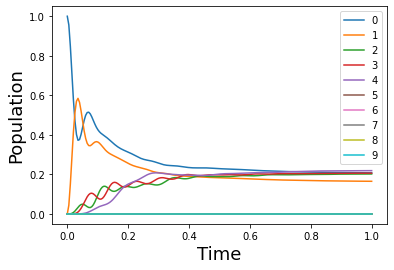

In [37]:
qudit10.playSim();
qudit10.showResults();

---

# Class `atomicQRegister()`

In [38]:
#atomQChip class


def perm_w_repl(n: int, m: int) -> Iterator[List[int]]:
    cur = []

    def perm_w_repl_recur(n_rec: int, m_rec: int) -> Iterator[List[int]]:
        nonlocal cur

        if n_rec == 0:
            yield cur
            return

        for i in range(1, m_rec + 1):
            cur = cur + [i]
            yield from perm_w_repl_recur(n_rec - 1, m_rec)
            cur.pop()

    yield from perm_w_repl_recur(n, m)
#transform from list to string
def lst2string(lst):
    return ''.join(str(e) for e in lst)
#convert bit-string to string
def bitstring2lst(string): 
    list1=[] 
    list1[:0]=string 
    return [ int(x) for x in list1 ] 
#transformation of qudit bit-string to qudit ket
def nqString2nqKet(psi0_string, bitdim=2):
    ket_lst = [c for c in psi0_string];
    psi = qt.Qobj();    
    counter=0;
    for i in range(len(ket_lst)):
        if counter==0:
            psi = qt.ket(ket_lst[i],bitdim);
            counter+=1;
        else:
            psi= qt.tensor(psi, qt.ket(ket_lst[i],bitdim));
    return psi
#generate binary bit-strings of n-bits and k-ones in bit
def bitCom(n, k):
    result = []
    for bits in itertools.combinations(range(n), k):
        s = ['0'] * n
        for bit in bits:
            s[bit] = '1'
        result.append(''.join(s))
    return result
#generate non-binary bit-strings of nr_at atoms and qdim qudit dimension
def mbitCom(nr_at=1, qdim=3):
    lst_comb=[];

    for i in perm_w_repl(nr_at, qdim):
        lst_comb.append([e - 1 for e in [*i]])
    return lst_comb

#set observables of dim^n Hilbert space system
def obs(at_nr, qdim=2):
    if qdim==2:
        bit_lst = [];
        for i in range(at_nr+1):
            bit_lst+=bitCom(at_nr,i);
        obs_lst = [];
        for e in bit_lst:
            ket = qt.basis([qdim]*at_nr, bitstring2lst(e));
            obs_lst.append((ket* ket.dag()) )
        obs_tot = sum(obs_lst)
        #possible to graphically check with: qt.matrix_histogram_complex(obs_tot)
        return obs_lst, bit_lst
    if qdim!=2:
        bit_lst = [lst2string(i) for i in mbitCom(at_nr, qdim)];
        obs_lst = [nqString2nqKet(i, qdim)*nqString2nqKet(i, qdim).dag() for i in bit_lst]
        return obs_lst, bit_lst

class atomicQRegister:
    
    """
        A class for develope models based in the n-level system of an atomic register. AQiPT atomQChip()
        class contain the basic toolbox for solve, time-dependent and -independent dynamics for 1 or
        more physical atomic qubits with the help of the AQiPT control-module using the class of 
        functions, pulses, tracks, sequence etc.

        The pulse class is the AQiPT core of the emulator for the dynamics of the qubits. From this
        class is possible to generate and store the Hamiltonians, Lindbladians, Observables, quantum
        registers maps and plot results for later use of other modules of AQiPT.


        Parameters
        ----------
        times : array_like
            Time of dynamics to be emulated.
        Nrlevels : int
            Number of levels of the quantum system.
        initState : int
            Initial state for the dynamics starting from 0 to any n.
        params : dict
            Dictionary with parameters of dynamcis e.g., couplings, detunings, dissipators, pulses
        name : str
            Label for the model

        Attributes
        ----------
        times : array_like
            Time of dynamics to be emulated.
        Nrlevels : int
            Number of levels of the quantum system.
        initState : Qobj() [QuTiP]
            Initial ensity matrix.
        dynParams : dict
            Dictionary with parameters of dynamcis e.g., couplings, detunings, dissipators, pulses
        Hamiltonian : Qobj() [QuTiP]
            Hamiltonian as QuTiP object
        cops : Qobj() list [QuTiP]
            List of Lindbladians as QuTiP objects
        mops : Qobj() list [QuTiP]
            List of Observables as QuTiP objects
        _ops : list
            Full list of operators that spam the system
        _basis : list 
            Full list of eigenstates of the system
        atomicRegister :
            Graph object of the n-level system
        _name : str
            Name of the model AQiPT object
        simOpts : Qobj() [QuTiP]
            Options QuTiP object for the mesolve() master equation solver
        simRes : Qobj() list [QuTiP]
            List of Qobj() related to the density matrix rho as function of time

        Methods
        -------
        playSIM()
            Solve QME for the Nrlevels-system at initState using params.
        buildHamiltonian()
            Construct Hamiltonians as QuTip object (Hermitian)
        buildLindbladians()
            Construct Lindbladians as QuTip object (Non-Hermitian)
        buildObservables()
            Construct Observables as QuTip object (Hermitian)
        getResult()
            Return result values from simulation as a list of QuTip objects (Hermitian)
        showResults()
            Plot results coming from the simulation
        registerMap()
            Plot the graph associated to the n-level system of the atomic quantum register
            
    """
    
    

    def __init__(self, lstAQR, initnState=None, name='DefaultQRegister', homogeneous=False):#times, Nrlevels, initState, params, name='model', NrQReg=1, Homogeneous=True):
        
        
        
        #atributes
        self._AMs = lstAQR
        
        self.times = lstAQR[0].times
        self.Nrlevels = reduce(lambda x, y: x * y, [AQR.Nrlevels for AQR in lstAQR])
        self.NrQReg = len(lstAQR)
        
        if initnState==None:
            self.lstinitState = [AQR.initState for AQR in lstAQR]
            self.initnState = None
        else:
            self.lstinitState = bitstring2lst(initnState)
            self.initnState = None
        
        self.lstHamiltonian = [AQR.Hamiltonian for AQR in lstAQR]
        self.lsttHamiltonian = []
        self.lstPulses = [AQR.Hpulses for AQR in lstAQR]
        self.nHamiltonian = None
        self.tnHamiltonian = None
        
        self.lstcops = [AQR.cops for AQR in lstAQR]
        self.ncops = None
        
        self.lstmops = [AQR.mops for AQR in lstAQR]
        self.nmops = None
        
        ops, basis = ops_nlvl(self.Nrlevels);
        self._ops = ops
        self._basis = basis
        self.atomicQChip = {}
        
        self._name = name
        self._homogeneous = homogeneous
        self.simOpts = qt.Options(nsteps=500, rtol=1e-7, max_step=10e-1)
        self.simRes = None
    
    def playSim(self, mode='free'):
        if mode=='free':
            self.simRes = qt.mesolve(self.nHamiltonian, qt.ket2dm(self.initnState), self.times, c_ops=self.ncops, e_ops=self.nmops, options=self.simOpts)
        elif mode=='control':
            self.simRes = qt.mesolve(self.tnHamiltonian, qt.ket2dm(self.initnState), self.times, c_ops=self.ncops, e_ops=self.nmops, options=self.simOpts)

            
    def buildNinitState(self):
        if self.initnState==None:
            self.initnState = qt.tensor(self.lstinitState)
        else:
            self.initnState = qt.tensor([qt.basis(lstAQR[i].Nrlevels,  self.lstinitState[i]) for i in range(len(self.lstinitState))]) 
        self.initnState.dims= [[self.Nrlevels],[1]]
        self.initnState.reshape = (self.Nrlevels, 1)
        

    def buildNHamiltonian(self):
        _idenLst = [iden(self._AMs[i].Nrlevels) for i in range(len(self._AMs))];
        _buf = []
        for i in range(len(self.lstHamiltonian)):
            _bufHamLst = _idenLst.copy() #copy identity ops list
            _bufHamLst[i] = self.lstHamiltonian[i] #substitute ith iden by ith Hamiltonian
            _buf.append(qt.tensor(_bufHamLst)) #save tensor product in buffer
        self.nHamiltonian = sum(_buf)
        self.nHamiltonian.dims= [[self.Nrlevels],[self.Nrlevels]]
        self.nHamiltonian.reshape= (self.Nrlevels, self.Nrlevels)
    
    def buildTNHamiltonian(self):
        _bufHQobjEVO = [];
        _bufHtDependency= [AM._lstHamiltonian for AM in self._AMs]
        _bufHStruct= [AM._lstHamiltonian for AM in self._AMs]
            
        _i=0;
        for H,oft in zip(_bufHStruct,_bufHtDependency):
            nH = [iden(self._AMs[i].Nrlevels) for i in range(len(self._AMs))]
            nH[_i]=H;
            print(nH)

            _bufHQobjEVO+= [[qt.tensor([nH]), oft]]
            
#             for element in range(len(AM.dynParams['couplings'])):
                
#                 _HStruct = AM.dynParams['couplings']['Coupling'+str(element)][1] * (AM._ops[(AM.dynParams['couplings']['Coupling'+str(element)][0])[0]*AM.Nrlevels + (AM.dynParams['couplings']['Coupling'+str(element)][0])[1]] + AM._ops[(AM.dynParams['couplings']['Coupling'+str(element)][0])[0]*AM.Nrlevels + (AM.dynParams['couplings']['Coupling'+str(element)][0])[1]].dag())
#                 _HQobjEVO.append([_HStruct, _HtDependency])

                
#                 _HtDependency = AM.dynParams['couplings']['Coupling'+str(element)][2]
#                 _HAQiPTpulses.append(_HtDependency)
            _i+=1;
            print(_bufHQobjEVO)
                
                
                                
        self.tnHamiltonian = _HQobjEVO
        self.Hpulses = _HAQiPTpulses
                    
    def buildNLindbladians(self):
        _idenLst = [iden(self._AMs[i].Nrlevels) for i in range(len(self._AMs))];
        _buf = []
        for i in range(len(self.lstcops)):
            _bufLindLst = _idenLst.copy() #copy identity ops list
            _bufLindLst[i] = sum(self.lstcops[i]) #substitute ith iden by ith Hamiltonian
            _buf.append(qt.tensor(_bufLindLst)) #save tensor product in buffer
        self.ncops = sum(_buf)
        self.ncops.dims= [[self.Nrlevels],[self.Nrlevels]]
        self.ncops.reshape= (self.Nrlevels, self.Nrlevels)
        
            
    def buildNObservables(self):
        self.nmops, labels = obs(1, self.Nrlevels)


    
    def add2Chip(self, Nrlevels, psi0, params, name):
        _newModel = atomicModel(self.times, Nrlevels, psi0, params, name)
        self._submodels.append(_newModel)
        return _newModel

    
    def getNHamiltonian(self):
        return self.nHamiltonian

    def getNLindbladian(self):
        return self.ncops
    
    def getNObservables(self):
        return self.nmops
    
    def getResult(self):
        return self.simRes
    
    def showResults(self, resultseq=None, figureSize=(10,6)):
        
        resultseq = self.simRes
        
        fig, axs = plt.subplots(figsize=figureSize);

        for i in range(len(resultseq.expect)):
            axs.plot(times, resultseq.expect[i], label=i);

        plt.legend();
        plt.xlabel('Time', fontsize=18);
        plt.ylabel('Population', fontsize=18)

        return fig, axs
    
    def registerMap(self, plotON=True):
        
        for state in range(self.Nrlevels):
            self.atomicRegister[state] = []
        
        for coupling in self.dynParams['couplings'].items():
            i, j = coupling[1][0];
            self.atomicRegister[i].append(j)
            self.atomicRegister[j].append(i)
        
        G = nx.MultiDiGraph(self.atomicRegister, create_using=nx.DiGraph, seed = 100)
        
        edgelist = []
        for dissipator in self.dynParams['dissipators'].items():    
            i,j = dissipator[1][0];
            if i==j:
                edgelist.append(tuple([i,j]));
        G.add_edges_from(edgelist)

        if plotON==True:
            pos = nx.circular_layout(G)
            nx.draw(G, with_labels=True, font_weight='regular',node_size=400, linewidths=5, font_size=15)
            nx.draw_networkx_edges(G, pos, edgelist=edgelist, arrowstyle="<|-", style="solid")
        return self.atomicRegister
    

## Preparing atomicModel() for atomicQRegister()

### Qubit

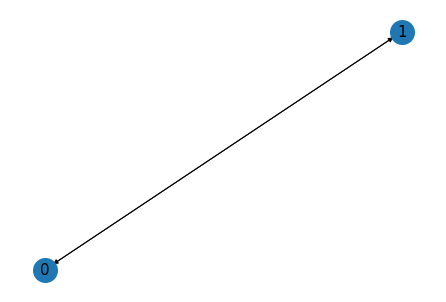

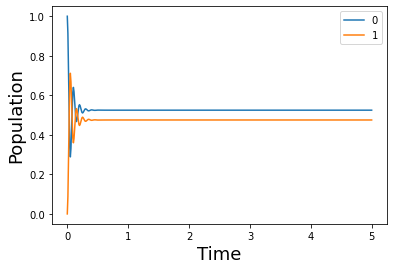

In [39]:
Nrlevels = 2; #nr of levels in the system
psi0 = 0; #initial state
"""
coupling0 -> CoupingRed-767nm
Detuning0 -> AOM 767nm
"""
times = np.linspace(0, 5, 500); #time of the dynamics
couplings = {'Coupling0': [[0,1], 2*np.pi*5,  None]}; #couplings list within the states [i,j], couplingValue, pulse
detunings = {'Detuning0': [[1,1], -2*np.pi*0.6,  None]}; #detuning list in the state i as [i,i], detuningValue, pulse          
dissipators = {'Dissipator0': [[0,1], 2*np.pi*3]}; #dissipator list within the states [i,j], dissipatorStrenght



params = {'couplings': couplings, 
          'detunings': detunings, 
          'dissipators': dissipators}; #wrapping dynamic params in dictionary

qubit = atomicModel(times, Nrlevels, psi0, params, name = '2-lvl')#, NrQReg=1, Homogeneous=True); #model class of AQiPT model(timeOfdynamics, NumberOfLevels, InitialState, DynamicParams, NameLabel)

qubitMap = qubit.registerMap(plotON=True); #defining the map of the AtomicQuantumRegister

qubit.buildHamiltonian(); #building Hamiltonians
qubit.buildLindbladians(); #building Lindbladians
qubit.buildObservables(); #building Observables
qubit.playSim(); #playing simulation
qubit.showResults(); #ploting

### Qutrit

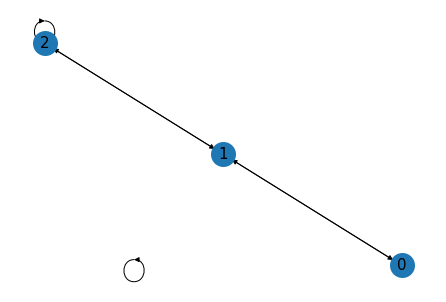

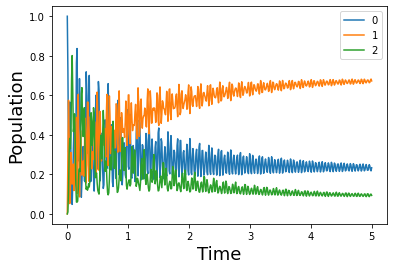

In [40]:
Nrlevels = 3; #nr of levels in the system
psi0 = 0; #initial state
times = np.linspace(0, 5, 500); #time of the dynamics

couplings = {'Coupling0': [[0,1], 2*np.pi*9,  None], 
             'Coupling1': [[1,2], 2*np.pi*6,  None]}; #couplings list within the states [i,j], couplingValue, pulse

detunings = {'Detuning0': [[1,1], -2*np.pi*10,  None],
             'Detuning1': [[2,2], 2*np.pi*5,  None]}; #detuning list in the state i as [i,i], detuningValue, pulse 

dissipators = {'Dissipator0': [[0,1],2*np.pi*3],
               'Dissipator0': [[1,2],2*np.pi*0.3],
               'Dissipator1': [[0,2],2*np.pi*0.1],
               'Dissipator2': [[2,2],2*np.pi*0]}; #dissipator list within the states [i,j], dissipatorStrenght

params = {'couplings': couplings, 
          'detunings': detunings, 
          'dissipators': dissipators}; #wrapping dynamic params in dictionary

qutrit = atomicModel(times, Nrlevels, psi0, params, name = '3-lvl'); #model class of AQiPT model(timeOfdynamics, NumberOfLevels, InitialState, DynamicParams, NameLabel)

qutritMap = qutrit.registerMap(plotON=True); #defining the map of the AtomicQuantumRegister

qutrit.buildHamiltonian(); #building Hamiltonians
qutrit.buildLindbladians(); #building Lindbladians
qutrit.buildObservables(); #building Observables
qutrit.playSim(mode='free'); #playing simulation
qutrit.showResults(); #ploting

# N Qubits

## 2 qubits (2, 2-lvl systems)

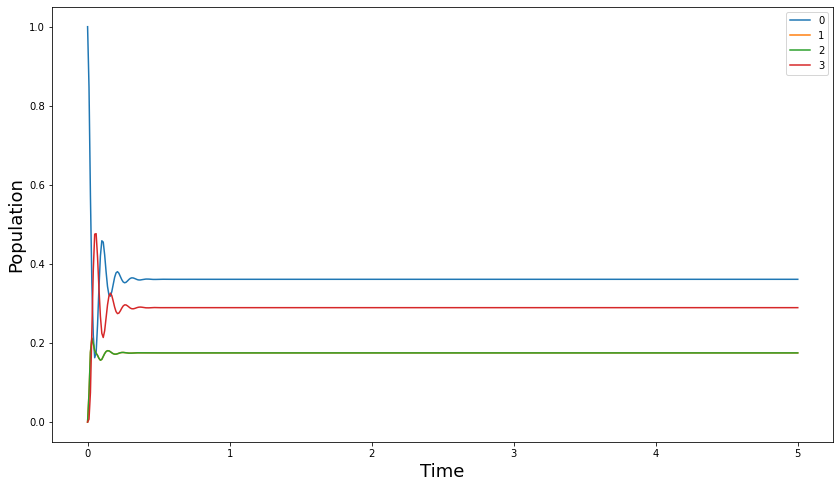

In [41]:
AtomicQC1 = atomicQRegister([qubit,qubit], name='qubit+qubit')
AtomicQC1.buildNHamiltonian()
AtomicQC1.buildNLindbladians()
AtomicQC1.buildNObservables()
AtomicQC1.buildNinitState()

# qt.hinton(AtomicQC1.nHamiltonian,xlabels=None, ylabels=None, title='Hamiltonian', ax=None);
# qt.hinton(qubit.Hamiltonian,xlabels=None, ylabels=None, title='Hamiltonian', ax=None);
# qt.hinton(qubit.Hamiltonian,xlabels=None, ylabels=None, title='Hamiltonian', ax=None);

AtomicQC1.playSim();
AtomicQC1.showResults(figureSize=(14,8));

## 2 qutrits (2, 3-lvl systems)

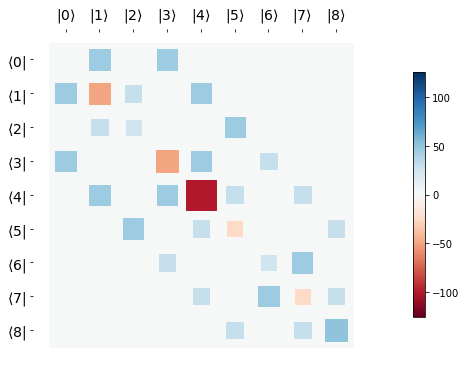

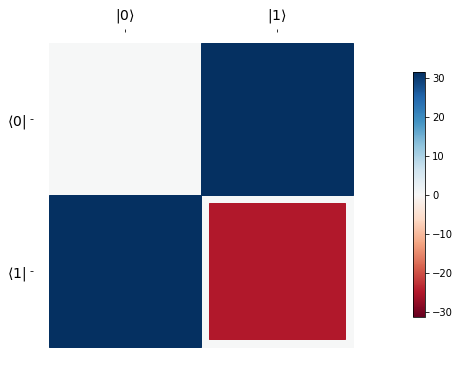

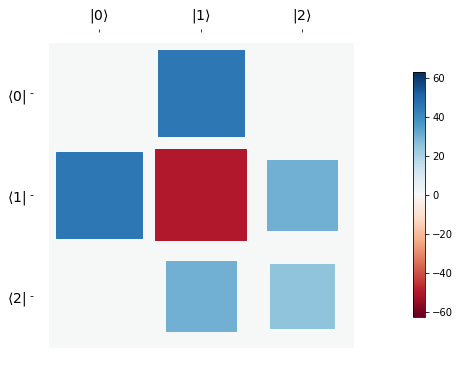

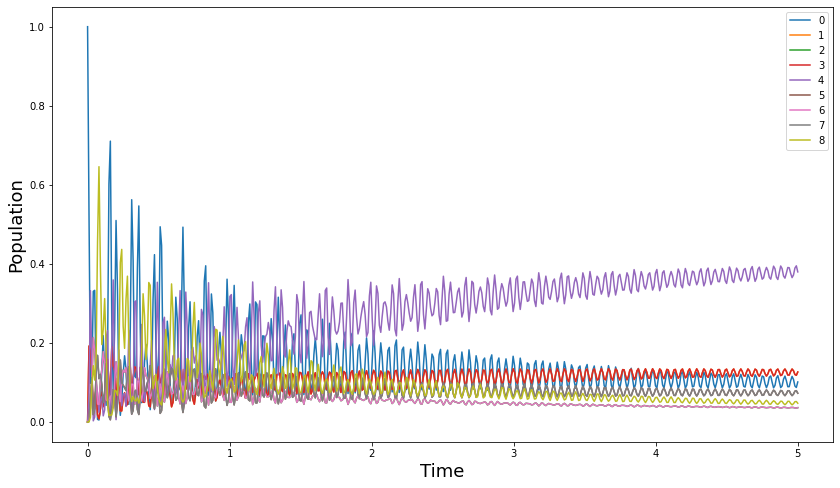

In [42]:
AtomicQC2 = atomicQRegister([qutrit,qutrit], name='qubit+qubit')
AtomicQC2.buildNHamiltonian()
AtomicQC2.buildNLindbladians()
AtomicQC2.buildNObservables()
AtomicQC2.buildNinitState()

qt.hinton(AtomicQC2.nHamiltonian,xlabels=None, ylabels=None, title='Hamiltonian', ax=None);
qt.hinton(qubit.Hamiltonian,xlabels=None, ylabels=None, title='Hamiltonian', ax=None);
qt.hinton(qutrit.Hamiltonian,xlabels=None, ylabels=None, title='Hamiltonian', ax=None);

AtomicQC2.playSim();
AtomicQC2.showResults(figureSize=(14,8));

## 1 qubit and 1 qutrit (2-lvl systems and 3-lvl systems)

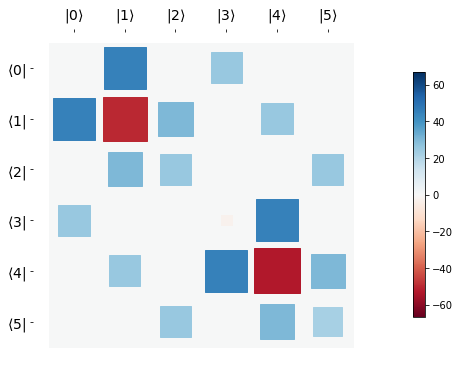

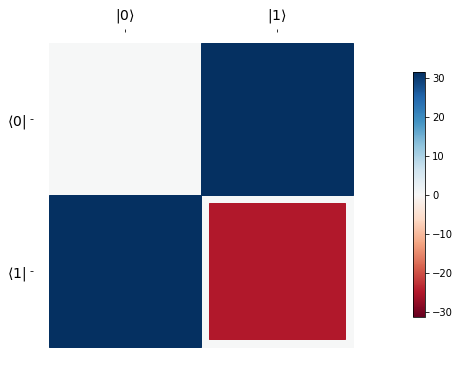

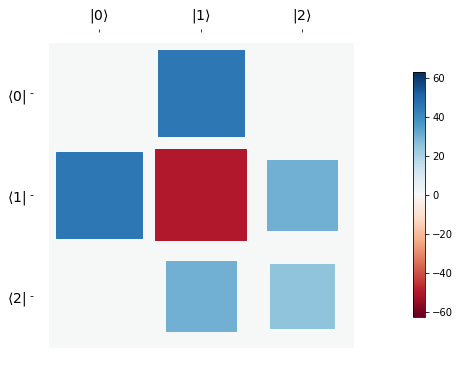

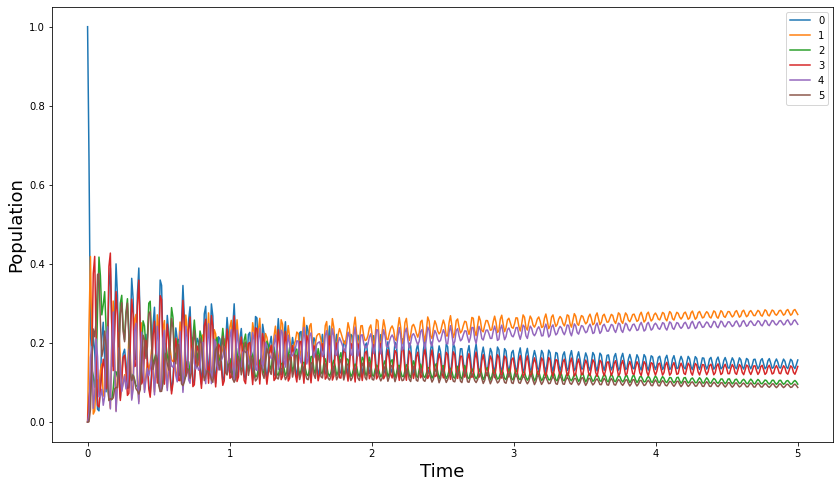

In [43]:
AtomicQC3 = atomicQRegister([qubit,qutrit], name='qubit+qutrit')
AtomicQC3.buildNHamiltonian()
AtomicQC3.buildNLindbladians()
AtomicQC3.buildNObservables()
AtomicQC3.buildNinitState()

qt.hinton(AtomicQC3.nHamiltonian,xlabels=None, ylabels=None, title='Hamiltonian', ax=None);
qt.hinton(qubit.Hamiltonian,xlabels=None, ylabels=None, title='Hamiltonian', ax=None);
qt.hinton(qutrit.Hamiltonian,xlabels=None, ylabels=None, title='Hamiltonian', ax=None);

AtomicQC3.playSim();
AtomicQC3.showResults(figureSize=(14,8));

# Including pulses

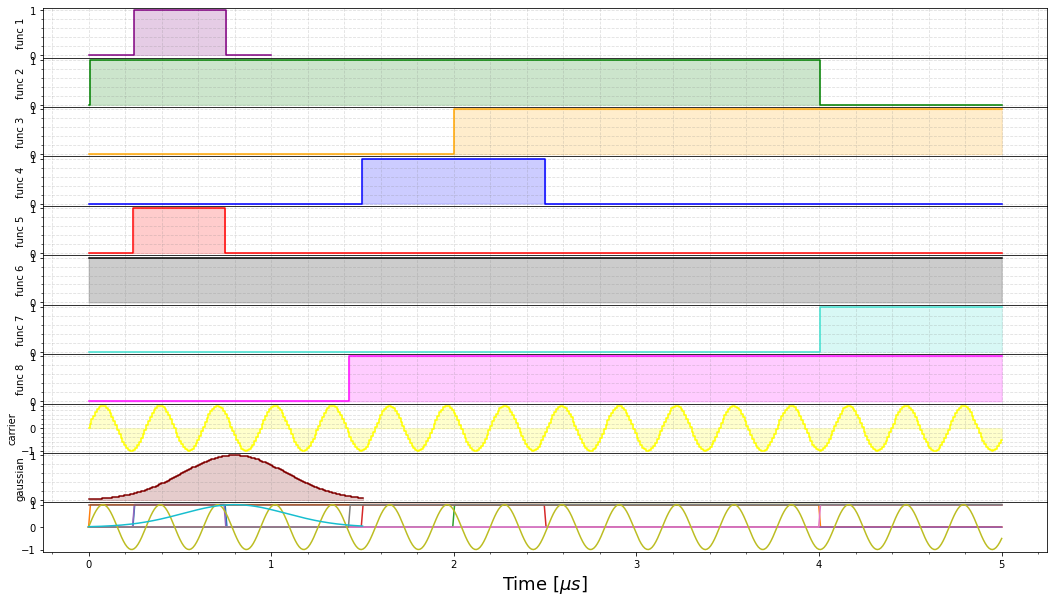

In [44]:
nr_physical_ops = 10;

#PULSE SPECIFICATIONS
args = {'sampling':500, 'bitdepth':16, 'time_dyn':5}; #dictionary of general parameters introduced by user
params = aqipt.general_params(args); #get params AQiPT object from dictionary
tbase = params.timebase(); #obtain time-base from params object

color_lst = ['purple', 'green', 'orange', 'blue', 'red',
             'black', 'turquoise', 'magenta', 'yellow', 'maroon', 
             'lime', 'sienna', 'limegreen', 'violet', 'dodgerblue']; #list of colors

#FUNCTION FOR PULSES
#function parameters
args_lst=[{'amp': 1, 't_o':0.5, 'width': 0.25, 'tp_window': 1, 'name': 'func 1', 'color': color_lst[0]},
         {'amp': 1, 't_o':2, 'width': 2,'tp_window': 5, 'name': 'func 2', 'color': color_lst[1]},
         {'amp': 1, 't_o':4, 'width': 2,'tp_window': 5, 'name': 'func 3', 'color': color_lst[2]},
         {'amp': 1, 't_o':2, 'width': 0.5,'tp_window': 5, 'name': 'func 4', 'color': color_lst[3]},
         {'amp': 1, 't_o':0.5, 'width': 0.25,'tp_window': 5, 'name': 'func 5', 'color': color_lst[4]},
         {'amp': 1, 't_o':2, 'width': 3.1,'tp_window': 5, 'name': 'func 6', 'color': color_lst[5]},
         {'amp': 1, 't_o':5, 'width': 1,'tp_window': 5, 'name': 'func 7', 'color': color_lst[6]},
         {'amp': 1, 't_o':4.75, 'width': 3.32,'tp_window': params.dyn_time, 'name': 'func 8', 'color': color_lst[7]},
         {'Amp':1, 'freq':20/(2*np.pi), 'phase':0,'tp_window': params.dyn_time, 'name': 'carrier', 'color': color_lst[8]},
         {'g_Amp':1, 'g_center': 0.8, 'g_std':0.2,'tp_window': 1.5, 'name': 'gaussian', 'color': color_lst[9]}];

fig, axs = plt.subplots(nr_physical_ops+1, 1, figsize=(18,10), sharex=True);
fig.subplots_adjust(hspace=0);

funcs_lst=[];
for _ in range(nr_physical_ops):

    #function creation
    tp_window = args_lst[_]['tp_window']; 
    
    if args_lst[_]['name'] == 'carrier':
        tp = np.linspace(0, tp_window, params.sampling);
        func, plot = aqipt.function(tp, args_lst[_]).sinusoidal();
        funcs_lst.append(func);
        
    elif args_lst[_]['name'] == 'gaussian':
        tp = np.linspace(0, tp_window, int((tp_window-0)*params.sampling/params.dyn_time));
        func, plot = aqipt.function(tp, args_lst[_]).gaussian();
        funcs_lst.append(func);
        
    else:
        tp = np.linspace(0, tp_window, int((tp_window-0)*params.sampling/params.dyn_time)); #time domain function
        func, plot = aqipt.function(tp, args_lst[_]).step(plotON=False);
        funcs_lst.append(func);
    
    #ploting
    axs[_].step(tp, func, color=args_lst[_]['color'], where='mid');
    axs[_].fill_between(tp, func, color=args_lst[_]['color'], step="mid", alpha=0.2);
    axs[_].set_ylabel(args_lst[_]['name']);
    axs[_].minorticks_on();
    axs[_].grid(b=True, which='both', color='gray', linestyle='--', alpha=0.25);
    plt.xlabel(r'Time $[\mu s]$', fontsize=18);

## Pulsed `pulsed_qubit1`

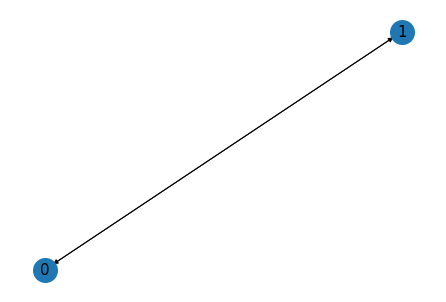

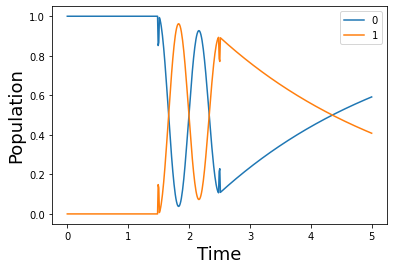

In [45]:
Nrlevels = 2; #nr of levels in the system
psi0 = 0; #initial state
"""
coupling0 -> CoupingRed-767nm
Detuning0 -> AOM 767nm detuning
Dissipator0 -> Spontaneous decay
"""
times = np.linspace(0, 5, 500); #time of the dynamics
couplings = {'Coupling0': [[0,1], 2*np.pi*100.55,  funcs_lst[3]]}; #couplings list within the states [i,j], couplingValue, pulse
detunings = {'Detuning0': [[1,1], -2*np.pi*20.6,  funcs_lst[5]]}; #detuning list in the state i as [i,i], detuningValue, pulse          
dissipators = {'Dissipator0': [[0,1], 2*np.pi*0.05]}; #dissipator list within the states [i,j], dissipatorStrenght



params = {'couplings': couplings, 
          'detunings': detunings, 
          'dissipators': dissipators}; #wrapping dynamic params in dictionary

pulsed_qubit1 = atomicModel(times, Nrlevels, psi0, params, name = '2-lvl')#, NrQReg=1, Homogeneous=True); #model class of AQiPT model(timeOfdynamics, NumberOfLevels, InitialState, DynamicParams, NameLabel)

qubitMap = pulsed_qubit1.registerMap(plotON=True); #defining the map of the AtomicQuantumRegister

# qubit.buildHamiltonian(); #building Hamiltonians
pulsed_qubit1.buildTHamiltonian(); #building Time-depnedent Hamiltonian
pulsed_qubit1.buildLindbladians(); #building Lindbladians
pulsed_qubit1.buildObservables(); #building Observables
pulsed_qubit1.playSim(mode='control'); #playing simulation
pulsed_qubit1.showResults(); #ploting

## Pulsed `pulsed_qubit2`

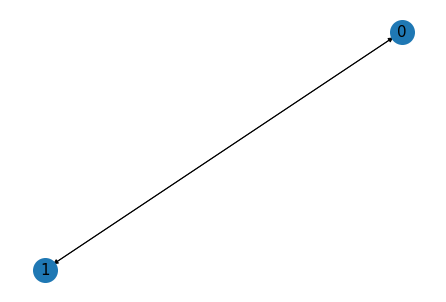

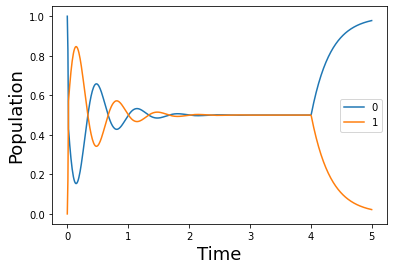

In [46]:
Nrlevels = 2; #nr of levels in the system
psi0 = 0; #initial state
"""
coupling0 -> CoupingRed-767nm
Detuning0 -> AOM 767nm detuning
Dissipator0 -> Spontaneous decay
"""
times = np.linspace(0, 5, 500); #time of the dynamics
couplings = {'Coupling0': [[0,1], 2*np.pi*100.55,  funcs_lst[1]]}; #couplings list within the states [i,j], couplingValue, pulse
detunings = {'Detuning0': [[1,1], -2*np.pi*10.6,  funcs_lst[5]]}; #detuning list in the state i as [i,i], detuningValue, pulse          
dissipators = {'Dissipator0': [[0,1], 2*np.pi*0.5]}; #dissipator list within the states [i,j], dissipatorStrenght



params = {'couplings': couplings, 
          'detunings': detunings, 
          'dissipators': dissipators}; #wrapping dynamic params in dictionary

pulsed_qubit2 = atomicModel(times, Nrlevels, psi0, params, name = '2-lvl')#, NrQReg=1, Homogeneous=True); #model class of AQiPT model(timeOfdynamics, NumberOfLevels, InitialState, DynamicParams, NameLabel)

qubitMap = pulsed_qubit2.registerMap(plotON=True); #defining the map of the AtomicQuantumRegister

# qubit.buildHamiltonian(); #building Hamiltonians
pulsed_qubit2.buildTHamiltonian(); #building Time-depnedent Hamiltonian
pulsed_qubit2.buildLindbladians(); #building Lindbladians
pulsed_qubit2.buildObservables(); #building Observables
pulsed_qubit2.playSim(mode='control'); #playing simulation
pulsed_qubit2.showResults(); #ploting

## Pulsed `atomicQRegister([pulsed_qubit1, pulsed_qubit2])`

In [47]:
AtomicQC_pulsed._AMs[0]._lstHamiltonian

NameError: name 'AtomicQC_pulsed' is not defined

In [ ]:
AtomicQC_pulsed = atomicQRegister([pulsed_qubit1,pulsed_qubit2], name='qubit+qubit') #build time-dependent quantum register
# AtomicQC_pulsed = atomicQRegister([qubit,qubit], name='qubit+qubit') #build time-dependent quantum register

# AtomicQC_pulsed.buildNHamiltonian(); #build N model Hamiltonian
AtomicQC_pulsed.buildTNHamiltonian(); #build time-dependent N model Hamiltonian
AtomicQC_pulsed.buildNLindbladians(); #build N model Lindabladians
AtomicQC_pulsed.buildNObservables(); #build N model Observables
AtomicQC_pulsed.buildNinitState(); #build N model initial state

# qt.hinton(AtomicQC_pulsed.nHamiltonian,xlabels=None, ylabels=None, title='Hamiltonian', ax=None);
# qt.hinton(AtomicQC_pulsed.Hamiltonian,xlabels=None, ylabels=None, title='Hamiltonian', ax=None);
# qt.hinton(AtomicQC_pulsed.Hamiltonian,xlabels=None, ylabels=None, title='Hamiltonian', ax=None);

AtomicQC_pulsed.playSim(mode='control');
AtomicQC_pulsed.showResults(figureSize=(14,8));

# Qubits interaction and X-talk

# Extra interaction mechanisms

# Footnote

In [ ]:
#libs summary
import types
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__
list(imports())

To Do:
>   
>   - N qubits **X**
>   - t-dependency (pulses) **X**
>   - Qubits interaction (depending of positions)
>   - Extra Hamiltonian terms e.g., B-fields interactions